In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

Using TensorFlow backend.


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenizer lowers the text and cleans up the punctuation

sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!',
    "Do you think my dog is amazing?"
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sentences= tokenizer.texts_to_sequences(sentences)
print(word_index)
print (sentences)

{'my': 1, 'love': 2, 'dog': 3, 'i': 4, 'you': 5, 'cat': 6, 'do': 7, 'think': 8, 'is': 9, 'amazing': 10}
[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]


In [5]:
# If you give new data to tokenizer which is not fit_on_texts

test_sent=["I really love my dog", "my dog is my bestie"]

print (tokenizer.texts_to_sequences(test_sent))

# you have lost new data like really and bestie because you dont have those words in the fit_on_texts method

[[4, 2, 1, 3], [1, 3, 9, 1]]


In [6]:
# So we have to add oov_token (out of vocabulary) in tokenizer
sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!',
    "Do you think my dog is amazing?"
]

tokenizer = Tokenizer(num_words = 100,oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sentences_token= tokenizer.texts_to_sequences(sentences)
print (tokenizer.word_index)
print (sentences_token)


{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]


In [7]:
print (tokenizer.texts_to_sequences(test_sent))

[[5, 1, 3, 2, 4], [2, 4, 10, 2, 1]]


In [8]:
sequence=tokenizer.texts_to_sequences(sentences)
padded=pad_sequences(sequence, maxlen=len(max((sentences),key=len).split(" ")),padding="post")
padded

array([[ 5,  3,  2,  4,  0,  0,  0],
       [ 5,  3,  2,  7,  0,  0,  0],
       [ 6,  3,  2,  4,  0,  0,  0],
       [ 8,  6,  9,  2,  4, 10, 11]])

Using Real data

In [9]:
# refer https://rishabhmisra.github.io/publications/
# refer https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy

import json

with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
print(len(word_index))

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post',maxlen=len(max((sentences),key=len).split(" ")))

print(padded[0])
print(padded.shape)

29657
[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
(26709, 29)


In [34]:
datastore[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [37]:
padded.shape

(26709, 29)

In [38]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [39]:
len(labels)

26709

In [40]:
sum(labels)

11724

## **Introduction to GloVe**

ref -https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

ref - https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469


GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix. Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.\
The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix. How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.

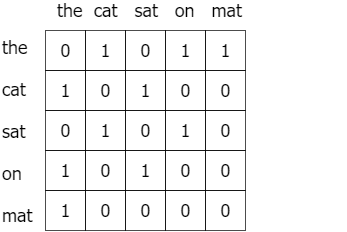

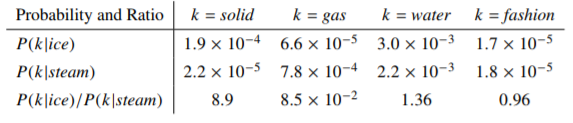

In [15]:
EMBEDDING_FILE = '/content/glove.6B.300d.txt'

In [16]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [20]:
#example showing the dimension of the vector representation of a word

embeddings_index["cheese"].shape

(300,)

In [41]:
x_train=padded[:int(len(padded)*0.8)]
y_train=labels[:int(len(padded)*0.8)]

x_test=padded[int(len(padded)*0.8):]
y_test=labels[int(len(padded)*0.8):]

In [42]:
x_train.shape

(21367, 29)

In [43]:
len(embeddings_index)

400000

In [86]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index

# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size increases by 1

nb_words =  len(word_index)+1
#this line is just to define the embedding matrix to required shape
embedding_matrix =  np.random.normal(emb_mean, emb_std, (nb_words, embed_size))



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [88]:
for word, i in word_index.items():
    
    embedding_vector = embeddings_index.get(word)
    #print (embedding_vector.shape)

    if embedding_vector is not None and i<len(word_index): 
      #print (embedding_vector.shape)
      embedding_matrix[i] = embedding_vector

In [89]:
all_embs.shape

(400000, 300)

In [92]:
embedding_matrix.shape

(29658, 300)

In [90]:
batch_size = 128
epochs = 2
embed_size = all_embs.shape[1]

In [93]:

#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=x_train.shape[1], trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 29, 300)           8897400   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 9,336,953
Trainable params: 9,336,953
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(x_train, np.array(y_train), batch_size = batch_size , validation_data = (x_test,np.array(y_test)) , epochs = 2)

Epoch 1/2
167/167 [==============================] - 106s 636ms/step - loss: 0.4032 - acc: 0.8123 - val_loss: 0.2910 - val_acc: 0.8793
Epoch 2/2
167/167 [==============================] - 109s 651ms/step - loss: 0.1435 - acc: 0.9466 - val_loss: 0.3509 - val_acc: 0.8746


In [97]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [98]:
cm = confusion_matrix(y_test,pred)
cm

array([[2729,  305],
       [ 365, 1943]])

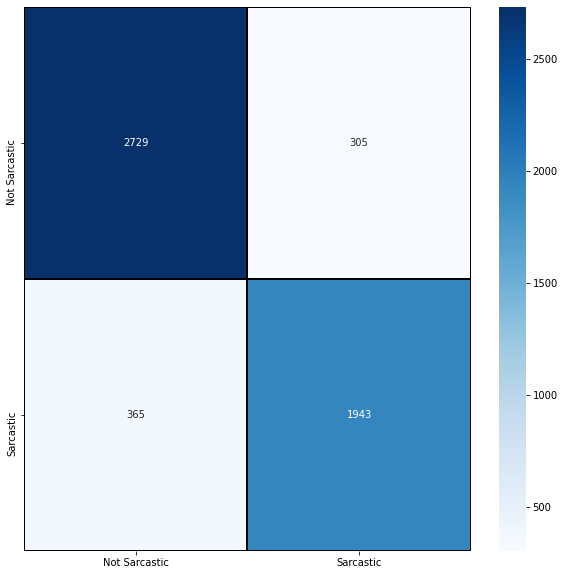

In [99]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])